In [304]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
import seaborn as sns
output_notebook()
# set font size 
from src.visualization.visualize import *
from src.models.train_model import *
plt.rcParams.update({'font.size': 16})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

data no fire has shape (77746, 15)


Text(0, 0.5, 'PM2.5')

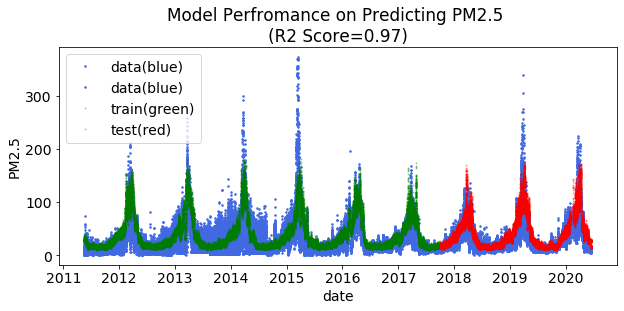

In [446]:
# load data and model 
data = Dataset('Chiang Mai')
data.load_()
pollutant = 'PM2.5'
# load model meta 
#with open(data.model_folder + 'model_meta.json') as f:
#    model_meta = json.load(f)[pollutant]
    
#print(model_meta['rf_score'])

data.fire_dict = {'w_speed': 4, 'shift': -24, 'roll': 108}
data.x_cols = ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_E', 'wind_N', 'wind_S', 'is_holiday', 'is_weekend', 'day_of_week',
       'time_of_day', 'fire_0_100', 'fire_100_400', 'fire_400_700',
       'fire_700_1000']

# build dataset 
data.feature_no_fire()
data.pollutant = pollutant
data.merge_fire(data.fire_dict)

rf_model = pickle.load(open(data.model_folder +f'PM25_rf_model.pkl','rb'))

data.split_data(split_ratio=[0.7, 0.3])
trn_index = data.split_list[0]
test_index = data.split_list[1]

xtrn, ytrn, x_cols = data.get_data_matrix(use_index=trn_index,x_cols=data.x_cols)
xtest, ytest, _ = data.get_data_matrix(use_index=test_index,x_cols=data.x_cols)

plt.figure(figsize=(10, 4))

# plot data 
plt.plot(trn_index,ytrn, marker='.', label='data(blue)',linewidth=0,alpha=1, markersize=3,color='royalblue')
plt.plot(test_index,ytest, marker='.', label='data(blue)',linewidth=0,alpha=1, markersize=3,color='royalblue')

plt.plot(trn_index,rf_model.predict(xtrn), marker='.', label='train(green)',linewidth=0,alpha=0.3, markersize=2,color='green')
plt.plot(test_index,rf_model.predict(xtest), marker='.', label='test(red)',linewidth=0,alpha=0.3, markersize=2, color='red')
 
plt.legend()
plt.title('Model Perfromance on Predicting PM2.5 \n(R2 Score=0.68)')
plt.xlabel('date')
plt.ylabel('PM2.5')

data no fire has shape (77746, 15)


Text(0, 0.5, 'PM2.5')

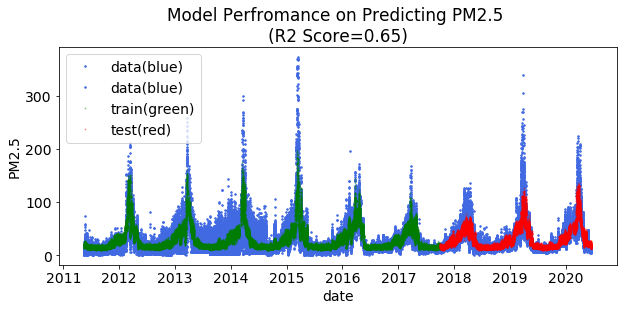

In [513]:
# load data and model 
data = Dataset('Chiang Mai')
data.load_()
pollutant = 'PM2.5'
# load model meta 
#with open(data.model_folder + 'model_meta.json') as f:
#    model_meta = json.load(f)[pollutant]
    
#print(model_meta['rf_score'])

data.fire_dict = {'w_speed': 4, 'shift': -24, 'roll': 108}
data.x_cols = ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM',
       'wind_E', 'wind_N', 'wind_S', 'is_holiday', 'is_weekend', 'day_of_week',
       'time_of_day', 'fire_0_100', 'fire_100_400', 'fire_400_700',
       'fire_700_1000']

# build dataset 
data.feature_no_fire()
data.pollutant = pollutant
data.merge_fire(data.fire_dict)

tpot_model = pickle.load(open(data.model_folder +f'PM25_tpot_model.pkl','rb'))

data.split_data(split_ratio=[0.7, 0.3])
trn_index = data.split_list[0]
test_index = data.split_list[1]

xtrn, ytrn, x_cols = data.get_data_matrix(use_index=trn_index,x_cols=data.x_cols)
xtest, ytest, _ = data.get_data_matrix(use_index=test_index,x_cols=data.x_cols)

plt.figure(figsize=(10, 4))

# plot data 
plt.plot(trn_index,ytrn, marker='.', label='data(blue)',linewidth=0,alpha=1, markersize=3,color='royalblue')
plt.plot(test_index,ytest, marker='.', label='data(blue)',linewidth=0,alpha=1, markersize=3,color='royalblue')

plt.plot(trn_index,tpot_model.predict(xtrn), marker='.', label='train(green)',linewidth=0,alpha=0.3, markersize=2,color='green')
plt.plot(test_index,tpot_model.predict(xtest), marker='.', label='test(red)',linewidth=0,alpha=0.3, markersize=2, color='red')
 
plt.legend()
plt.title('Model Perfromance on Predicting PM2.5 \n(R2 Score=0.65)')
plt.xlabel('date')
plt.ylabel('PM2.5')

In [448]:
trn_data = data.data.loc[trn_index]
test_data = data.data.loc[test_index]

wea_cols = ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W',
       'is_rain']

fire_cols = ['fire_0_100', 'fire_100_400', 'fire_400_700', 'fire_700_1000']
# datetime information cols use the data from the test set 
date_cols = ['is_holiday', 'is_weekend', 'day_of_week', 'time_of_day']

wea = trn_data[wea_cols]
fire = trn_data[fire_cols]

In [449]:
n_samples = 100

year_list = trn_data.index.year.unique()
year_sam = np.arange(len(year_list)) + 1
year_sam = year_sam.cumsum()/year_sam.cumsum().sum()
year_sam = (year_sam*n_samples).astype(int)
year_sam

array([ 1,  3,  7, 11, 17, 25, 33])

In [450]:
# add datetimes columns for weather and fire data for the training data 
wea['year'] = wea.index.year
wea['day_of_year'] = wea.index.dayofyear
wea['hour'] = wea.index.hour

fire['year'] = fire.index.year
fire['day_of_year'] = fire.index.dayofyear
fire['hour'] = fire.index.hour

In [451]:
time_range = pd.date_range(start=test_data.index.min(), end=test_data.index.max(), freq='h')

In [255]:
def get_sample(test_datetime, wea, fire,year_list, year_samples, day_err=7, hour_err=1):
    """Randomsamples data in each columns 
    Args:
    
    Returns: 
    
    """
    
    #get date range
    start_date = test_datetime - pd.Timedelta(f'{day_err} days')
    end_date = test_datetime + pd.Timedelta(f'{day_err} days')
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    date_range = date_range.dayofyear.to_list()
     
    # get hour range 
    start_date = test_datetime - pd.Timedelta(f'{hour_err} hours')
    end_date = test_datetime + pd.Timedelta(f'{hour_err} hours')
    hour_range = pd.date_range(start=start_date, end=end_date, freq='h')
    hour_range = hour_range.hour
    
    # get wether sample 
    # select the data
    fire_samples = []
    wea_samples = []
    for year, year_sample in zip(year_list, year_samples):
        # select deata for the year
        wea_sam = wea[(wea['year']==year) & wea['day_of_year'].isin(date_range) & wea['hour'].isin(hour_range)]
         
        if len(wea_sam) > 0:
             wea_samples.append(wea_sam.sample(year_sample,replace=True))
            
        # select deata for the year
        fire_sam = fire[(fire['year']==year) & fire['day_of_year'].isin(date_range) & fire['hour'].isin(hour_range)]
     
        if len(fire_sam) > 0:
             fire_samples.append(fire_sam.sample(year_sample,replace=True))

    wea_samples = pd.concat(wea_samples, ignore_index=True).sample(frac=1).reset_index(drop=True)
    fire_samples = pd.concat(fire_samples, ignore_index=True).sample(frac=1).reset_index(drop=True)
    wea_samples['datetime'] = test_datetime
    
    data_samples = pd.concat([wea_samples, fire_samples], axis=1)
    
    return data_samples.drop(['day_of_year','hour','year'],axis=1)

In [452]:
%%time

data_samples_all = []
data_samples_len = []
for test_datetime in tqdm(time_range[::5]):
    
    data_samples = get_sample(test_datetime, wea, fire,year_list, year_samples=year_sam,day_err=10,hour_err=2)
    data_samples_all.append(data_samples)
    data_samples_len.append(len(data_samples))
    
data_samples_all = pd.concat(data_samples_all,ignore_index=True)
# add calenda information 
data_samples_all = data_samples_all.set_index('datetime')
data_samples_all = add_calendar_info(data_samples_all)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 4748/4748 [06:58<00:00, 11.35it/s]


Wall time: 7min


# Full Data

In [470]:
x = data_samples_all[x_cols].values
ypred = rf_model.predict(x)
ypred_df = pd.Series(ypred , index=data_samples_all.index)
ypred_df.head()

datetime
2017-10-02 17:00:00    19.306513
2017-10-02 17:00:00    15.875196
2017-10-02 17:00:00    17.638705
2017-10-02 17:00:00    18.928665
2017-10-02 17:00:00    18.794306
dtype: float64

In [458]:
q_list = [0.01, 0.5, 0.70,  0.99]

band_df = []
for q in q_list:
    
    band = ypred_df.groupby(level=0).quantile(q=q)
    band_index = band.index
    band = smooth(band.values,window_len=41)
    
    band_df.append(pd.DataFrame(band, index=band_index, columns=['q'+ str(q)]))
    
band_df = pd.concat(band_df, axis=1)

sea_pred = band_df.resample('d').max().copy()
sea_pred['dayofyear'] = sea_pred.index.dayofyear
sea_pred['year'] = sea_pred.index.year

# add winter day by substratcing the first day of july
winterday = sea_pred['dayofyear'] - 182
# get rid of the negative number
winter_day_max = winterday.max()
winterday[winterday < 0] = winterday[winterday < 0] + 182 + winter_day_max  
sea_pred['winter_day'] = winterday

sea_pred = sea_pred.groupby('winter_day').max()
sea_pred = sea_pred.drop(['dayofyear','year'],axis=1)

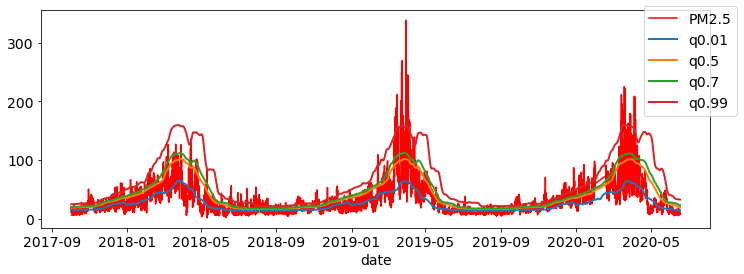

In [459]:
plt.figure(figsize=(12,4))
#ypred_df.plot(alpha=0.3,color='royalblue')

plt.plot(test_index, ytest,color='red',label='data')
plt.plot(band_df, linewidth=2)

plt.xlabel('date')
plt.legend(['PM2.5'] + band_df.columns.to_list(), bbox_to_anchor=(1.05, 1.05),frameon=True)


In [471]:
q_list = [0.10, 0.5, 0.70,  0.90]

band_df = []
for q in q_list:
    
    band = ypred_df.groupby(level=0).quantile(q=q)
    band = smooth(band.values,window_len=41)
    
    band_df.append(pd.DataFrame(band, index=band_index, columns=['q'+ str(q)]))
    
band_df = pd.concat(band_df, axis=1)
print(band_df.max())

q0.1     78.693193
q0.5    102.396729
q0.7    112.220412
q0.9    137.465278
dtype: float64


In [464]:
sea_pred = band_df.resample('d').max().copy()
sea_pred['dayofyear'] = sea_pred.index.dayofyear
sea_pred['year'] = sea_pred.index.year

# add winter day by substratcing the first day of july
winterday = sea_pred['dayofyear'] - 182
# get rid of the negative number
winter_day_max = winterday.max()
winterday[winterday < 0] = winterday[winterday < 0] + 182 + winter_day_max  
sea_pred['winter_day'] = winterday

sea_pred = sea_pred.groupby('winter_day').max()
sea_pred = sea_pred.drop(['dayofyear','year'],axis=1)

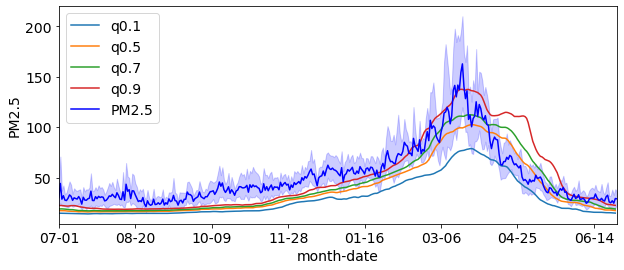

In [465]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.plot(sea_pred)
winter_day_dict = plot_season_avg(data.poll_df, 'PM2.5', ax, plot_error=True)

ax.legend(band_df.columns.to_list() + ['PM2.5'] )

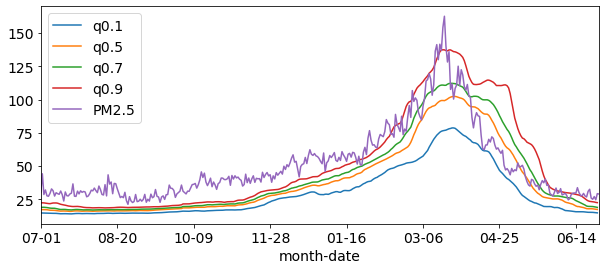

In [466]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.plot(sea_pred)
winter_day_dict = plot_season_avg(data.poll_df, 'PM2.5', ax, plot_error=False)

ax.legend(band_df.columns.to_list() + ['PM2.5'])

# Fire Zone 0-100

In [ ]:
per = 0.5
data_senario = data_samples_all.copy()
data_senario['fire_0_100'] = data_senario['fire_0_100']*(1-per)
x = data_senario[x_cols].values
ypred = rf_model.predict(x)
ypred = tpot_model.predict(x)

ypred_df = pd.Series(ypred , index=data_samples_all.index)

In [ ]:
q_list = [0.10, 0.5, 0.70,  0.90]

band_df = []
for q in q_list:
    
    band = ypred_df.groupby(level=0).quantile(q=q)
    band = smooth(band.values,window_len=41)
    
    band_df.append(pd.DataFrame(band, index=band_index, columns=['q'+ str(q)]))
    
band_df = pd.concat(band_df, axis=1)
print(band_df.max())

sea_pred = band_df.resample('d').max().copy()
sea_pred['dayofyear'] = sea_pred.index.dayofyear
sea_pred['year'] = sea_pred.index.year

# add winter day by substratcing the first day of july
winterday = sea_pred['dayofyear'] - 182
# get rid of the negative number
winter_day_max = winterday.max()
winterday[winterday < 0] = winterday[winterday < 0] + 182 + winter_day_max  
sea_pred['winter_day'] = winterday

sea_pred = sea_pred.groupby('winter_day').max()
sea_pred = sea_pred.drop(['dayofyear','year'],axis=1)

In [ ]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.plot(sea_pred)
winter_day_dict = plot_season_avg(data.poll_df, 'PM2.5', ax, plot_error=False)

ax.legend(band_df.columns.to_list() + ['PM2.5'])
plt.title(f'fire_0_100 reduced {per}')

# Fire Zone 100 - 400

In [514]:
per = 0.5
data_senario = data_samples_all.copy()
data_senario['fire_100_400'] = data_senario['fire_100_400']*(1-per)
x = data_senario[x_cols].values
ypred = rf_model.predict(x)
ypred = tpot_model.predict(x)
ypred_df = pd.Series(ypred , index=data_samples_all.index)

In [515]:
q_list = [0.10, 0.5, 0.70,  0.90]

band_df = []
for q in q_list:
    
    band = ypred_df.groupby(level=0).quantile(q=q)
    band = smooth(band.values,window_len=41)
    
    band_df.append(pd.DataFrame(band, index=band_index, columns=['q'+ str(q)]))
    
band_df = pd.concat(band_df, axis=1)

sea_pred = band_df.resample('d').max().copy()
sea_pred['dayofyear'] = sea_pred.index.dayofyear
sea_pred['year'] = sea_pred.index.year

# add winter day by substratcing the first day of july
winterday = sea_pred['dayofyear'] - 182
# get rid of the negative number
winter_day_max = winterday.max()
winterday[winterday < 0] = winterday[winterday < 0] + 182 + winter_day_max  
sea_pred['winter_day'] = winterday

sea_pred = sea_pred.groupby('winter_day').max()
sea_pred = sea_pred.drop(['dayofyear','year'],axis=1)

In [516]:
band_df.max()

q0.1     48.017666
q0.5     66.101982
q0.7     87.554863
q0.9    107.807687
dtype: float64

Text(0.5, 1.0, 'fire_100_400 reduced by 0.5')

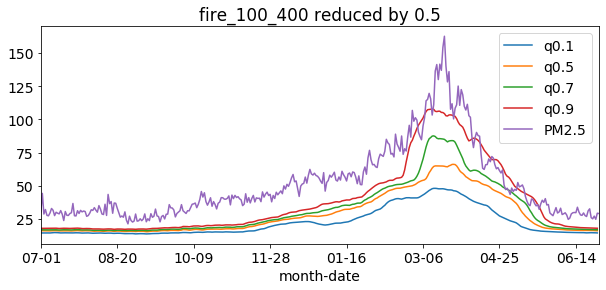

In [517]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.plot(sea_pred)
winter_day_dict = plot_season_avg(data.poll_df, 'PM2.5', ax, plot_error=False)

ax.legend(band_df.columns.to_list() + ['PM2.5'])
plt.title(f'fire_100_400 reduced by {per}')

Text(0.5, 1.0, 'fire_100_400 reduced by 0.9')

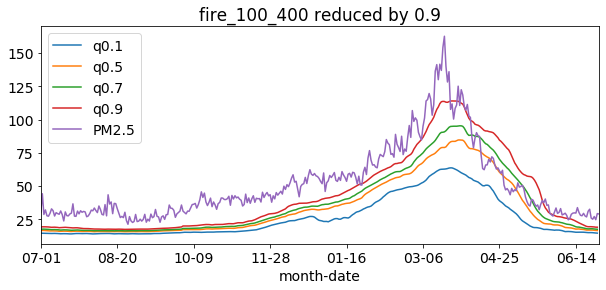

In [490]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.plot(sea_pred)
winter_day_dict = plot_season_avg(data.poll_df, 'PM2.5', ax, plot_error=False)

ax.legend(band_df.columns.to_list() + ['PM2.5'])
plt.title(f'fire_100_400 reduced by {per}')

# Fire fire_700_1000

In [492]:
per = 0.9
data_senario = data_samples_all.copy()
data_senario['fire_700_1000'] = data_senario['fire_700_1000']*(1-per)
x = data_senario[x_cols].values
ypred = rf_model.predict(x)
ypred_df = pd.Series(ypred , index=data_samples_all.index)

In [493]:
q_list = [0.10, 0.5, 0.70,  0.90]

band_df = []
for q in q_list:
    
    band = ypred_df.groupby(level=0).quantile(q=q)
    band = smooth(band.values,window_len=41)
    
    band_df.append(pd.DataFrame(band, index=band_index, columns=['q'+ str(q)]))
    
band_df = pd.concat(band_df, axis=1)

sea_pred = band_df.resample('d').max().copy()
sea_pred['dayofyear'] = sea_pred.index.dayofyear
sea_pred['year'] = sea_pred.index.year

# add winter day by substratcing the first day of july
winterday = sea_pred['dayofyear'] - 182
# get rid of the negative number
winter_day_max = winterday.max()
winterday[winterday < 0] = winterday[winterday < 0] + 182 + winter_day_max  
sea_pred['winter_day'] = winterday

sea_pred = sea_pred.groupby('winter_day').max()
sea_pred = sea_pred.drop(['dayofyear','year'],axis=1)

In [494]:
band_df.max()

q0.1     73.089119
q0.5     90.697973
q0.7     95.910935
q0.9    105.113667
dtype: float64

Text(0.5, 1.0, 'fire_700_1000 reduced by 0.9')

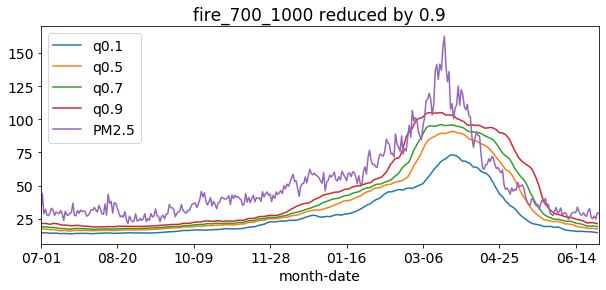

In [495]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.plot(sea_pred)
winter_day_dict = plot_season_avg(data.poll_df, 'PM2.5', ax, plot_error=False)

ax.legend(band_df.columns.to_list() + ['PM2.5'])
plt.title(f'fire_700_1000 reduced by {per}')

# Both fire_0_100, fire_100_400

In [508]:
per = 0.8
data_senario = data_samples_all.copy()
data_senario['fire_0_100'] = data_senario['fire_0_100']*(1-per)
data_senario['fire_100_400'] = data_senario['fire_100_400']*(1-per)
data_senario['fire_700_1000'] = data_senario['fire_700_1000']*(1-per)
x = data_senario[x_cols].values
ypred = rf_model.predict(x)
ypred_df = pd.Series(ypred , index=data_samples_all.index)

In [509]:
q_list = [0.10, 0.5, 0.70,  0.90]

band_df = []
for q in q_list:
    
    band = ypred_df.groupby(level=0).quantile(q=q)
    band = smooth(band.values,window_len=41)
    
    band_df.append(pd.DataFrame(band, index=band_index, columns=['q'+ str(q)]))
    
band_df = pd.concat(band_df, axis=1)

sea_pred = band_df.resample('d').max().copy()
sea_pred['dayofyear'] = sea_pred.index.dayofyear
sea_pred['year'] = sea_pred.index.year

# add winter day by substratcing the first day of july
winterday = sea_pred['dayofyear'] - 182
# get rid of the negative number
winter_day_max = winterday.max()
winterday[winterday < 0] = winterday[winterday < 0] + 182 + winter_day_max  
sea_pred['winter_day'] = winterday

sea_pred = sea_pred.groupby('winter_day').max()
sea_pred = sea_pred.drop(['dayofyear','year'],axis=1)

In [510]:
band_df.max()

q0.1     54.890106
q0.5     69.131824
q0.7     84.389701
q0.9    102.466667
dtype: float64

Text(0.5, 1.0, 'fire_0_1000 reduced by 0.8')

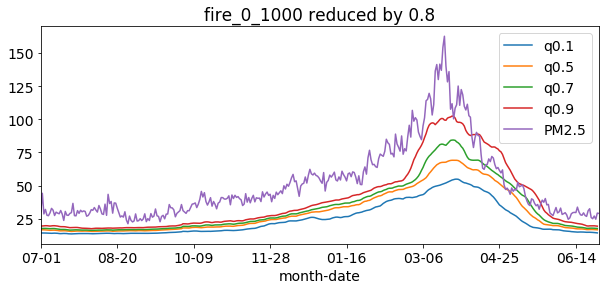

In [511]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.plot(sea_pred)
winter_day_dict = plot_season_avg(data.poll_df, 'PM2.5', ax, plot_error=False)

ax.legend(band_df.columns.to_list() + ['PM2.5'])
plt.title(f'fire_0_1000 reduced by {per}')

# Redo prediction

In [372]:
trn_data = data.data.loc[trn_index]
test_data = data.data.loc[test_index]

wea_cols = ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W',
       'is_rain']

fire_cols = ['fire_0_100', 'fire_100_400', 'fire_400_700', 'fire_700_1000','PM2.5_lag_1']
# datetime information cols use the data from the test set 
date_cols = ['is_holiday', 'is_weekend', 'day_of_week', 'time_of_day']

wea = trn_data[wea_cols]
fire = trn_data[fire_cols]

In [373]:
n_samples = 100

year_list = trn_data.index.year.unique()
year_sam = np.arange(len(year_list)) + 1
year_sam = year_sam.cumsum()/year_sam.cumsum().sum()
year_sam = (year_sam*n_samples).astype(int)
year_sam

array([ 1,  3,  7, 11, 17, 25, 33])

In [374]:
# add datetimes columns for weather and fire data for the training data 
wea['year'] = wea.index.year
wea['day_of_year'] = wea.index.dayofyear
wea['hour'] = wea.index.hour

fire['year'] = fire.index.year
fire['day_of_year'] = fire.index.dayofyear
fire['hour'] = fire.index.hour

In [357]:
time_range = pd.date_range(start=test_data.index.min(), end=test_data.index.max(), freq='h')

In [376]:
time_range[0]
data_samples = get_sample(test_datetime, wea, fire,year_list, year_samples=year_sam,day_err=10,hour_err=2)
 # add calenda information 
data_samples = data_samples.set_index('datetime')
data_samples = add_calendar_info(data_samples)

data_senario = data_samples.copy()
x = data_senario[x_cols].values
ypred = rf_model.predict(x)
ypred_df = pd.Series(ypred , index=data_samples.index)
ypred_df

datetime
2020-06-15 05:00:00     9.669351
2020-06-15 05:00:00     8.103136
2020-06-15 05:00:00    39.879509
2020-06-15 05:00:00    18.205744
2020-06-15 05:00:00     8.253032
                         ...    
2020-06-15 05:00:00    12.869852
2020-06-15 05:00:00    19.454590
2020-06-15 05:00:00     8.367445
2020-06-15 05:00:00     8.579019
2020-06-15 05:00:00    21.763022
Length: 97, dtype: float64

In [380]:
time_range[1]
data_samples = get_sample(time_range[1], wea, fire,year_list, year_samples=year_sam,day_err=10,hour_err=2)
# add calenda information 
data_samples = data_samples.set_index('datetime')
data_samples = add_calendar_info(data_samples)

data_samples['PM2.5_lag_1'] = np.random.choice(ypred,size=len(data_samples), replace=True)

data_senario = data_samples.copy()
x = data_senario[x_cols].values
ypred = rf_model.predict(x)
ypred_df = pd.Series(ypred , index=data_samples.index)

In [408]:
%%time
ypred_all_list = []
for i, test_datetime in tqdm(enumerate(time_range[::5])):
    data_samples = get_sample(test_datetime, wea, fire,year_list, year_samples=year_sam,day_err=10,hour_err=2)
    # add calenda information 
    data_samples = data_samples.set_index('datetime')
    data_samples = add_calendar_info(data_samples)

    if i > 0:
        data_samples['PM2.5_lag_1'] = np.random.choice(ypred,size=len(data_samples), replace=True)
    
    data_senario = data_samples.copy()
    x = data_senario[x_cols].values
    ypred = rf_model.predict(x)
    ypred_df = pd.DataFrame(ypred , index=data_samples.index)
    ypred_all_list.append(ypred_df)

ypred_all = pd.concat(ypred_all_list,ignore_index=False)        


4744it [14:15,  5.55it/s]


Wall time: 14min 15s


In [424]:
q_list = [ 0.01, 0.25, 0.5, 0.75, 0.99]

band_df = []
for q in q_list:
    
    band = ypred_all.groupby(level=0).quantile(q=q)
    band_index = band.index
    band = smooth(band.values.reshape(-1),window_len=41)
    
    band_df.append(pd.DataFrame(band, index=band_index, columns=['q'+ str(q)]))
    
band_df = pd.concat(band_df, axis=1)
print(band_df.max())

sea_pred = band_df.resample('d').max().copy()
sea_pred['dayofyear'] = sea_pred.index.dayofyear
sea_pred['year'] = sea_pred.index.year

# add winter day by substratcing the first day of july
winterday = sea_pred['dayofyear'] - 182
# get rid of the negative number
winter_day_max = winterday.max()
winterday[winterday < 0] = winterday[winterday < 0] + 182 + winter_day_max  
sea_pred['winter_day'] = winterday

sea_pred = sea_pred.groupby('winter_day').max()
sea_pred = sea_pred.drop(['dayofyear','year'],axis=1)

q0.01    54.300340
q0.25    60.548868
q0.5     65.059691
q0.75    70.940758
q0.99    82.378062
dtype: float64


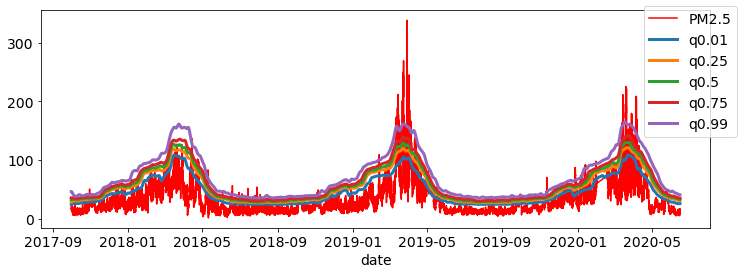

In [425]:
plt.figure(figsize=(12,4))
#ypred_df.plot(alpha=0.3,color='royalblue')

plt.plot(test_index, ytest,color='red',label='data')
plt.plot(band_df*2, linewidth=3)


plt.xlabel('date')
plt.legend(['PM2.5'] + band_df.columns.to_list() , bbox_to_anchor=(1.05, 1.05),frameon=True)

Text(0.5, 1.0, 'normal behavior')

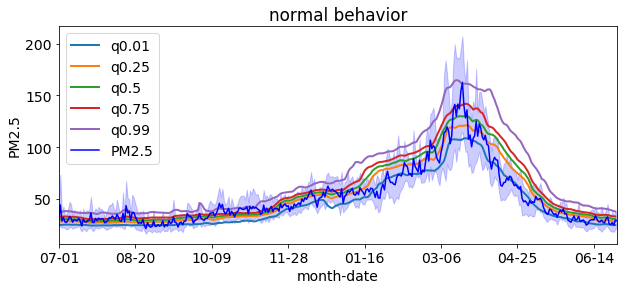

In [428]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.plot(sea_pred*2,linewidth=2)
winter_day_dict = plot_season_avg(data.poll_df, 'PM2.5', ax, plot_error=True)

ax.legend(band_df.columns.to_list() + ['PM2.5'])
plt.title(f'normal behavior')

In [439]:
col = 'fire_0_100'
per = 0.7

ypred_all_list = []
for i, test_datetime in tqdm(enumerate(time_range[::5])):
    data_samples = get_sample(test_datetime, wea, fire,year_list, year_samples=year_sam,day_err=10,hour_err=2)
    # add calenda information 
    data_samples = data_samples.set_index('datetime')
    data_samples = add_calendar_info(data_samples)

    if i > 0:
        data_samples['PM2.5_lag_1'] = np.random.choice(ypred,size=len(data_samples), replace=True)
    
    data_senario = data_samples.copy()
    data_senario[col] = data_senario[col]*per
    x = data_senario[x_cols].values
    ypred = rf_model.predict(x)
    ypred_df = pd.DataFrame(ypred , index=data_samples.index)
    ypred_all_list.append(ypred_df)

ypred_all = pd.concat(ypred_all_list,ignore_index=False)    

4744it [14:13,  5.56it/s]


In [440]:
q_list = [ 0.01, 0.25, 0.5, 0.75, 0.99]

band_df = []
for q in q_list:
    
    band = ypred_all.groupby(level=0).quantile(q=q)
    band_index = band.index
    band = smooth(band.values.reshape(-1),window_len=41)
    
    band_df.append(pd.DataFrame(band, index=band_index, columns=['q'+ str(q)]))
    
band_df = pd.concat(band_df, axis=1)
print(band_df.max())

sea_pred = band_df.resample('d').max().copy()
sea_pred['dayofyear'] = sea_pred.index.dayofyear
sea_pred['year'] = sea_pred.index.year

# add winter day by substratcing the first day of july
winterday = sea_pred['dayofyear'] - 182
# get rid of the negative number
winter_day_max = winterday.max()
winterday[winterday < 0] = winterday[winterday < 0] + 182 + winter_day_max  
sea_pred['winter_day'] = winterday

sea_pred = sea_pred.groupby('winter_day').max()
sea_pred = sea_pred.drop(['dayofyear','year'],axis=1)

q0.01    53.699700
q0.25    59.748754
q0.5     64.831086
q0.75    70.318734
q0.99    80.274553
dtype: float64


Text(0.5, 1.0, 'fire_0_100 reduced to 0.7')

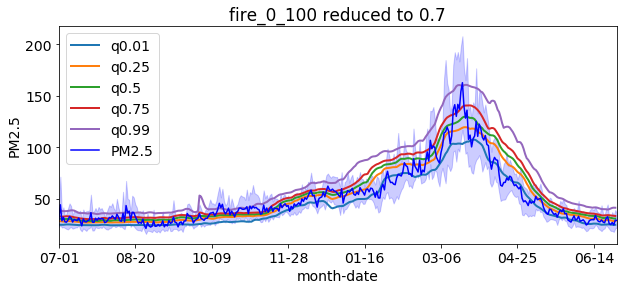

In [441]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.plot(sea_pred*2,linewidth=2)
winter_day_dict = plot_season_avg(data.poll_df, 'PM2.5', ax, plot_error=True)

ax.legend(band_df.columns.to_list() + ['PM2.5'])
plt.title(col + f' reduced to {per}')

In [442]:
col = 'fire_100_400'
per = 0.50

ypred_all_list = []
for i, test_datetime in tqdm(enumerate(time_range[::5])):
    data_samples = get_sample(test_datetime, wea, fire,year_list, year_samples=year_sam,day_err=10,hour_err=2)
    # add calenda information 
    data_samples = data_samples.set_index('datetime')
    data_samples = add_calendar_info(data_samples)

    if i > 0:
        data_samples['PM2.5_lag_1'] = np.random.choice(ypred,size=len(data_samples), replace=True)
    
    data_senario = data_samples.copy()
    data_senario[col] = data_senario[col]*per
    x = data_senario[x_cols].values
    ypred = rf_model.predict(x)
    ypred_df = pd.DataFrame(ypred , index=data_samples.index)
    ypred_all_list.append(ypred_df)

ypred_all = pd.concat(ypred_all_list,ignore_index=False)    

4744it [29:33,  2.67it/s]


In [443]:
q_list = [ 0.01, 0.25, 0.5, 0.75, 0.99]

band_df = []
for q in q_list:
    
    band = ypred_all.groupby(level=0).quantile(q=q)
    band_index = band.index
    band = smooth(band.values.reshape(-1),window_len=41)
    
    band_df.append(pd.DataFrame(band, index=band_index, columns=['q'+ str(q)]))
    
band_df = pd.concat(band_df, axis=1)
print(band_df.max())

sea_pred = band_df.resample('d').max().copy()
sea_pred['dayofyear'] = sea_pred.index.dayofyear
sea_pred['year'] = sea_pred.index.year

# add winter day by substratcing the first day of july
winterday = sea_pred['dayofyear'] - 182
# get rid of the negative number
winter_day_max = winterday.max()
winterday[winterday < 0] = winterday[winterday < 0] + 182 + winter_day_max  
sea_pred['winter_day'] = winterday

sea_pred = sea_pred.groupby('winter_day').max()
sea_pred = sea_pred.drop(['dayofyear','year'],axis=1)

q0.01    50.663191
q0.25    56.732371
q0.5     60.230633
q0.75    64.129567
q0.99    75.328384
dtype: float64


Text(0.5, 1.0, 'fire_100_400 reduced to 0.5')

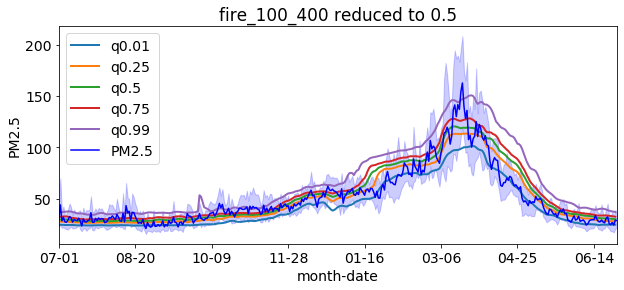

In [444]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.plot(sea_pred*2,linewidth=2)
winter_day_dict = plot_season_avg(data.poll_df, 'PM2.5', ax, plot_error=True)

ax.legend(band_df.columns.to_list() + ['PM2.5'])
plt.title(col + f' reduced to {per}')